In [1]:
# !pip install sklearn
# !pip install tqdm
# !pip install ipywidgets

In [1]:
import matplotlib.pyplot as plt
import json
%matplotlib inline

# AWS imports
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

## Bell State

### Local Simulator

Counter({'00': 50098, '11': 49902})


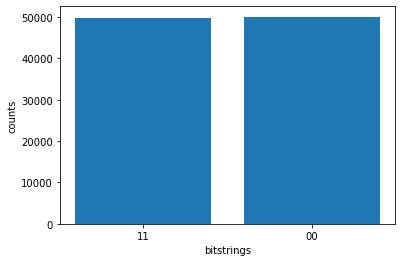

CPU times: user 678 ms, sys: 23.9 ms, total: 702 ms
Wall time: 701 ms


In [2]:
%%time
# Create Bell State
bell = Circuit().h(0).cnot(control=0, target=1)
# set up device
device = LocalSimulator()
# run circuit
result = device.run(bell, shots=100000).result()
assert all(result.measurements[:, 0] == result.measurements[:, 1])
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

# viz
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.show()

### Braket simulator

In [3]:
# changed
with open("config.json", "r") as f:
    config = json.load(f)

s3_folder = (config["my_bucket"], config["my_prefix"])
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

Counter({'11': 50124, '00': 49876})


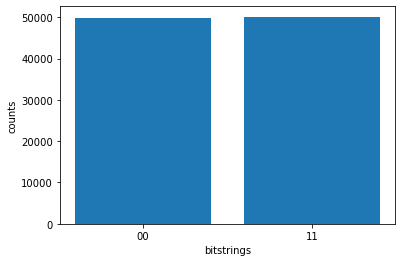

CPU times: user 1.28 s, sys: 24 ms, total: 1.3 s
Wall time: 10.2 s


In [4]:
%%time
# run circuit
result = device.run(bell, s3_destination_folder=s3_folder, shots=100000).result()
assert all(result.measurements[:, 0] == result.measurements[:, 1])
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

# viz
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.show()

### QPU Device

In [5]:
# changed
with open("config.json", "r") as f:
    config = json.load(f)

s3_folder = (config["my_bucket"], config["my_prefix"])
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

Counter({'00': 3, '11': 2})


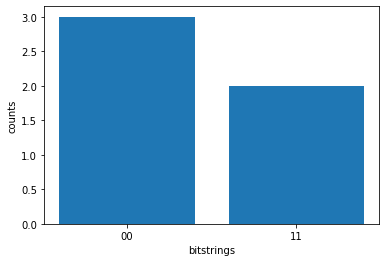

CPU times: user 1.55 s, sys: 83.9 ms, total: 1.63 s
Wall time: 10min 27s


In [6]:
%%time
# run circuit
result = device.run(bell, s3_destination_folder=s3_folder, shots=5).result()
# assert all(result.measurements[:, 0] == result.measurements[:, 1])
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

# viz
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.show()

In [7]:
result.measurements

array([[0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1]])

## PennyLane

### Bell State

In [8]:
import pennylane as qml
from tqdm.notebook import tqdm
import collections
from pennylane import numpy as np
import matplotlib.pyplot as plt
import json

In [9]:
dev = qml.device('default.qubit', shots=100000, wires=2)

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))

result = circuit()
assert all(result[0] == result[1])

Counter({1: 100276, -1: 99724})


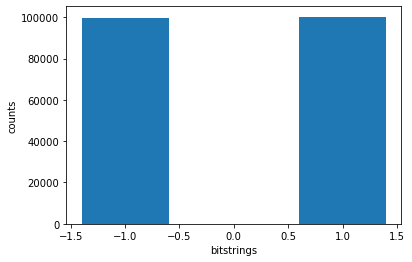

In [10]:
# viz
counts = collections.Counter(result.ravel())
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.show()

## Gradient

In [11]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100)

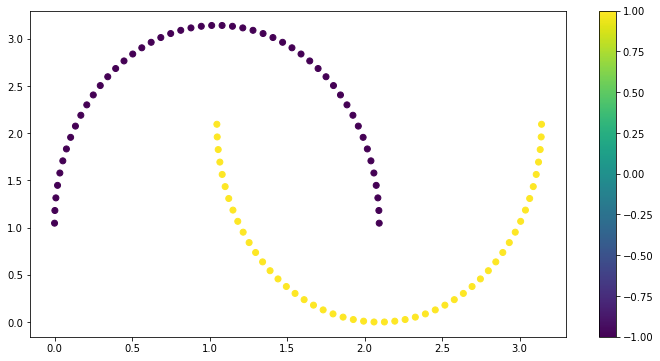

In [12]:
def normalize(x):
    min_ = x.min()
    max_ = x.max()
    return np.pi * (x - min_) / (max_ - min_)

x[:, 0] = normalize(x[:, 0])
x[:, 1] = normalize(x[:, 1])
y = y * 2 - 1

plt.figure(figsize=(12, 6))
cb = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar(cb)
plt.show()

In [13]:
dev = qml.device("default.qubit", 2)

def encoding(x1, x2):
    qml.RY(x1, wires=0)
    qml.RY(x2, wires=1)
    qml.RZ(x1, wires=0)
    qml.RZ(x2, wires=1)
    qml.CZ(wires=[0, 1])
    
def layer(theta):
    qml.Rot(theta[0, 0], theta[0, 1], theta[0, 2], wires=0)
    qml.Rot(theta[1, 0], theta[1, 1], theta[1, 2], wires=1)
    qml.CZ(wires=[0, 1])
    
@qml.qnode(dev)
def node(x1, x2, q):
    encoding(x1, x2)
    for q_ in q:
        layer(q_)

    return qml.expval(qml.PauliZ(0) @ qml.PauliY(1))

def apply_node(x, q):
    res = []
    for x_ in x:
        vqc_output = node(x_[0], x_[1], q[0])
        res.append(vqc_output + q[1])

    return res

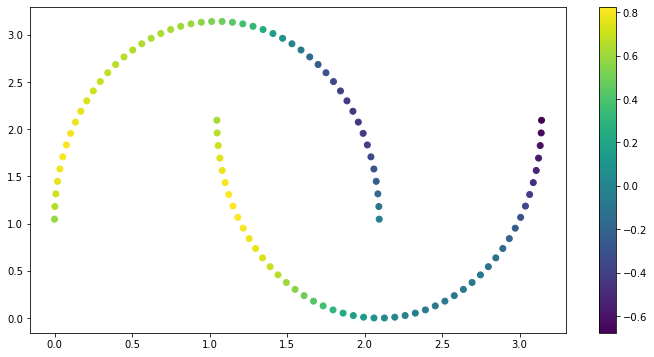

In [14]:
np.random.seed(42)
q = (np.random.uniform(-np.pi, np.pi, size=(4, 2, 3)), 0.0)

plt.figure(figsize=(12, 6))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()

In [15]:
def cost(q, x, y):
    preds = np.array(apply_node(x, q))
    return np.mean(np.square(preds - y))

def acc(q, x, y):
    preds = np.sign(apply_node(x, q))
    res = 0
    for p_, y_ in zip(preds, y):
        if np.abs(y_ - p_) <= 1e-2:
            res += 1

    return res / y.shape[0]

In [16]:
opt = qml.optimize.GradientDescentOptimizer(stepsize=0.05)
acc_ = []
cost_ = []
ii = []
for i in tqdm(range(75)):
    batch = np.random.randint(0, len(x), (10,))
    x_batch = x[batch, :]
    y_batch = y[batch]
    q = opt.step(lambda q_: cost(q_, x_batch, y_batch), q)

    if i % 5 == 0:
        ii.append(i)
        acc_.append(acc(q, x, y))
        cost_.append(cost(q, x, y))

  0%|          | 0/75 [00:00<?, ?it/s]

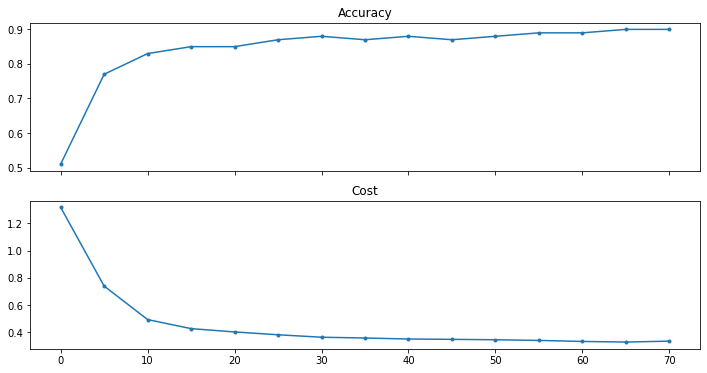

In [17]:
f, ax = plt.subplots(2, figsize=(12, 6), sharex=True)
ax[0].plot(ii, acc_, ".-")
ax[0].set_title("Accuracy")
ax[1].plot(ii, cost_, ".-")
ax[1].set_title("Cost")
plt.show()

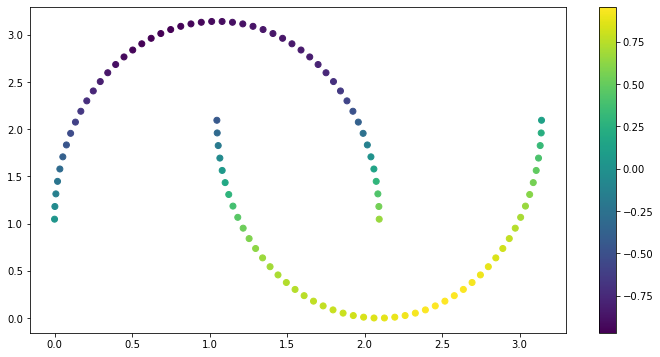

In [18]:
plt.figure(figsize=(12, 6))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()